
# 02 — Embeddings (FM) and Baselines
This notebook loads the cleaned interaction sequences and produces:
- **Popularity** and **ItemKNN** baselines
- (Optional) **Item text embeddings** using a small FM/LLM encoder (e.g., E5/BGE)
- A simple **text‑embedding retrieval** baseline
- A saved metrics report for quick comparison

> Tip: keep `engine='fastparquet'` while your environment has PyArrow extension issues.


In [1]:

# --- Config & imports ---------------------------------------------------------
import os, json, math, gc
from pathlib import Path
import numpy as np
import pandas as pd

# Matplotlib is used for simple charts (no seaborn)
import matplotlib.pyplot as plt

# Paths
PROJECT_ROOT = Path.home() / "KAUST-Project"   # /home/kamalyy/KAUST-Project
OUT_DIR = PROJECT_ROOT / "data" / "processed" / "online_retail_II"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Reading defaults (use fastparquet to avoid pyarrow registry issues)
READ_KW = dict(engine='fastparquet')

# Load artifacts produced in 01_data_prep
items      = pd.read_parquet(OUT_DIR/'item_id_map.parquet', **READ_KW)
users      = pd.read_parquet(OUT_DIR/'customer_id_map.parquet', **READ_KW)
seq_train  = pd.read_parquet(OUT_DIR/'sequences_train.parquet', **READ_KW)
seq_val    = pd.read_parquet(OUT_DIR/'sequences_val.parquet', **READ_KW)
seq_test   = pd.read_parquet(OUT_DIR/'sequences_test.parquet', **READ_KW)

n_items = len(items); n_users = len(users)
print(f"Items: {n_items} | Users: {n_users}")
print("Train/Val/Test:", seq_train.shape, seq_val.shape, seq_test.shape)

# Helper to parse history string -> list[int]
def parse_hist(s):
    if not isinstance(s, str) or not s.strip():
        return []
    return [int(x) for x in s.strip().split()]

# Metrics: Recall@K and NDCG@K for a single positive label per row
def recall_at_k(preds, truth):
    return float(truth in preds)

def ndcg_at_k(preds, truth):
    # rank starts at 1
    try:
        rank = preds.index(truth) + 1
        return 1.0 / math.log2(rank + 1.0)
    except ValueError:
        return 0.0

def evaluate_list(df, recommender_fn, K=20, sample=None, seed=42):
    if sample is not None and sample < len(df):
        df = df.sample(sample, random_state=seed)
    hits = 0.0; ndcgs = 0.0
    for hist, pos in zip(df['history_idx'].values, df['pos_item_idx'].values):
        h = parse_hist(hist)
        recs = list(recommender_fn(h, K=K))
        hits += recall_at_k(recs, int(pos))
        ndcgs += ndcg_at_k(recs, int(pos))
    n = len(df)
    return {
        f"Recall@{K}": hits / n if n else 0.0,
        f"NDCG@{K}": ndcgs / n if n else 0.0,
        "n_eval": n
    }

# A small utility to persist metrics
def save_metrics(d, name):
    metrics_path = OUT_DIR / 'metrics_baselines.json'
    if metrics_path.exists():
        with open(metrics_path, 'r', encoding='utf-8') as f:
            cur = json.load(f)
    else:
        cur = {}
    cur[name] = d
    with open(metrics_path, 'w', encoding='utf-8') as f:
        json.dump(cur, f, indent=2, ensure_ascii=False)
    print(f"Saved metrics for {name} -> {metrics_path}")


Items: 4446 | Users: 5748
Train/Val/Test: (592183, 6) (74819, 6) (75377, 6)



## Popularity baseline
A non‑personalized baseline: recommend the most frequent items observed in **train**.


In [2]:

# --- Popularity baseline ------------------------------------------------------
pop_order = seq_train['pos_item_idx'].value_counts().index.to_numpy()

def recommend_popularity(hist, K=20):
    return pop_order[:K]

metrics_pop_val  = evaluate_list(seq_val,  recommend_popularity, K=10, sample=10000)
metrics_pop_test = evaluate_list(seq_test, recommend_popularity, K=10, sample=10000)

print("Popularity (Val): ", metrics_pop_val)
print("Popularity (Test):", metrics_pop_test)

save_metrics(metrics_pop_val,  'popularity_val')
save_metrics(metrics_pop_test, 'popularity_test')


Popularity (Val):  {'Recall@10': 0.0241, 'NDCG@10': 0.012388110364965982, 'n_eval': 10000}
Popularity (Test): {'Recall@10': 0.0242, 'NDCG@10': 0.012231280725142688, 'n_eval': 10000}
Saved metrics for popularity_val -> /home/kamalyy/KAUST-Project/data/processed/online_retail_II/metrics_baselines.json
Saved metrics for popularity_test -> /home/kamalyy/KAUST-Project/data/processed/online_retail_II/metrics_baselines.json



## ItemKNN baseline (co‑occurrence → cosine)
We approximate item‑item similarity using co‑occurrence across pseudo‑users (hashing users into buckets for memory efficiency).


In [3]:

# --- ItemKNN baseline ---------------------------------------------------------
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

# Build item x pseudo-user matrix
M = 4096  # number of user buckets; increase if memory allows
rows = []; cols = []
for uid, hist, pos in zip(seq_train['customer_id'].values,
                          seq_train['history_idx'].values,
                          seq_train['pos_item_idx'].values):
    u = int(uid) % M
    # use set to avoid heavy duplicate counts within the same sequence
    for it in set(parse_hist(hist) + [int(pos)]):
        rows.append(it); cols.append(u)

data = np.ones(len(rows), dtype=np.float32)
X = csr_matrix((data, (rows, cols)), shape=(len(items), M))
Xn = normalize(X, axis=1)

# Cosine similarity via dot product of normalized rows
S = Xn @ Xn.T  # sparse

def recommend_itemknn(hist, K=20, neighbors=200):
    if not hist:
        return pop_order[:K]
    cand = defaultdict(float)
    for it in hist[-20:]:  # last 20 items from history
        sim_row = S.getrow(it)
        idx = sim_row.indices[:neighbors]
        val = sim_row.data[:neighbors]
        for j, v in zip(idx, val):
            cand[j] += float(v)
    # remove seen items
    for it in set(hist):
        cand.pop(it, None)
    if not cand:
        return pop_order[:K]
    top = sorted(cand.items(), key=lambda x: x[1], reverse=True)[:K]
    return [j for j,_ in top]

metrics_knn_val  = evaluate_list(seq_val,  recommend_itemknn, K=20, sample=10000, seed=123)
metrics_knn_test = evaluate_list(seq_test, recommend_itemknn, K=20, sample=10000, seed=124)

print("ItemKNN (Val): ", metrics_knn_val)
print("ItemKNN (Test):", metrics_knn_test)

save_metrics(metrics_knn_val,  'itemknn_val')
save_metrics(metrics_knn_test, 'itemknn_test')

# free some memory
del X, Xn, S; gc.collect()


ItemKNN (Val):  {'Recall@20': 0.0017, 'NDCG@20': 0.000539158333598795, 'n_eval': 10000}
ItemKNN (Test): {'Recall@20': 0.0012, 'NDCG@20': 0.00042437984154320763, 'n_eval': 10000}
Saved metrics for itemknn_val -> /home/kamalyy/KAUST-Project/data/processed/online_retail_II/metrics_baselines.json
Saved metrics for itemknn_test -> /home/kamalyy/KAUST-Project/data/processed/online_retail_II/metrics_baselines.json


66


## (Optional) Item text embeddings with a Foundation Model
Use a small sentence encoder (e.g., `intfloat/e5-small-v2` or `BAAI/bge-small-en-v1.5`) to embed the **item descriptions** once.  
These vectors are later useful for retrieval and cold‑start.


In [4]:

# --- Item text embeddings (optional) -----------------------------------------
!conda uninstall sentence-transformers
ITEMS_CLEAN_PATH = OUT_DIR / 'items_clean.parquet'

try:
    items_clean = pd.read_parquet(ITEMS_CLEAN_PATH, **READ_KW).merge(items, on='stock_code', how='inner')
    model_name = "intfloat/e5-small-v2"  # or "BAAI/bge-small-en-v1.5"
    try:
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer(model_name)
        desc  = items_clean['description'].fillna('').astype(str).tolist()
        emb   = model.encode(desc, normalize_embeddings=True, batch_size=256, show_progress_bar=True)
        np.save(OUT_DIR/'item_text_emb.npy', emb)
        items_clean[['item_idx']].to_parquet(OUT_DIR/'item_text_index.parquet', index=False, engine='fastparquet')
        print("Saved embeddings:", emb.shape, "->", OUT_DIR/'item_text_emb.npy')
    except Exception as e:
        print("[warn] sentence-transformers not available or model load failed:", e)
        print("Skip this cell or run locally with internet access to download the model.")
except Exception as e:
    print("[warn] Could not load items_clean:", e)


Jupyter detected...
2 channel Terms of Service accepted

PackagesNotFoundError: The following packages are missing from the target environment:
  - sentence-transformers




Batches:   0%|          | 0/18 [00:00<?, ?it/s]

/home/kamalyy/miniconda3/envs/cs323/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Saved embeddings: (4446, 384) -> /home/kamalyy/KAUST-Project/data/processed/online_retail_II/item_text_emb.npy



## (Optional) Text‑embedding retrieval baseline
If `item_text_emb.npy` exists, we build a nearest‑neighbors index and score by similarity to the **average of the user’s recent item vectors** (text only). This is a simple proxy for FM‑based retrieval.


In [5]:

# --- Text-embedding retrieval baseline (optional) ----------------------------
emb_path = OUT_DIR/'item_text_emb.npy'
idx_path = OUT_DIR/'item_text_index.parquet'

def recommend_textemb(hist, K=20, recent=10):
    # Fallback to popularity if embeddings not available
    if not emb_path.exists() or not idx_path.exists() or not hist:
        return pop_order[:K]
    emb = np.load(emb_path)
    idx = pd.read_parquet(idx_path, **READ_KW)['item_idx'].to_numpy()
    # Build a simple ANN with sklearn (cosine)
    from sklearn.neighbors import NearestNeighbors
    from sklearn.preprocessing import normalize
    emb_n = normalize(emb)
    nn = NearestNeighbors(metric='cosine', algorithm='brute')
    nn.fit(emb_n)
    # history vector = mean of recent item vectors
    h = [i for i in hist[-recent:] if i < len(emb_n)]
    if not h:
        return pop_order[:K]
    q = emb_n[h].mean(axis=0, keepdims=True)
    dist, nbrs = nn.kneighbors(q, n_neighbors=min(K*5, len(emb_n)))
    # convert distance->similarity and filter seen
    cand = []
    for j, d in zip(nbrs[0].tolist(), dist[0].tolist()):
        if j in set(hist):
            continue
        cand.append((j, 1.0 - float(d)))
    cand.sort(key=lambda x: x[1], reverse=True)
    top = [j for j,_ in cand[:K]]
    return top if top else pop_order[:K]

metrics_txt_val  = evaluate_list(seq_val,  recommend_textemb, K=20, sample=5000, seed=202)
metrics_txt_test = evaluate_list(seq_test, recommend_textemb, K=20, sample=5000, seed=203)

print("TextEmb (Val): ", metrics_txt_val)
print("TextEmb (Test):", metrics_txt_test)

save_metrics(metrics_txt_val,  'textemb_val')
save_metrics(metrics_txt_test, 'textemb_test')


TextEmb (Val):  {'Recall@20': 0.0088, 'NDCG@20': 0.0030493189421092453, 'n_eval': 5000}
TextEmb (Test): {'Recall@20': 0.0062, 'NDCG@20': 0.0023484604011382404, 'n_eval': 5000}
Saved metrics for textemb_val -> /home/kamalyy/KAUST-Project/data/processed/online_retail_II/metrics_baselines.json
Saved metrics for textemb_test -> /home/kamalyy/KAUST-Project/data/processed/online_retail_II/metrics_baselines.json



## Quick plots
Simple bar charts of Recall/NDCG for the baselines. (One chart per figure; using matplotlib.)


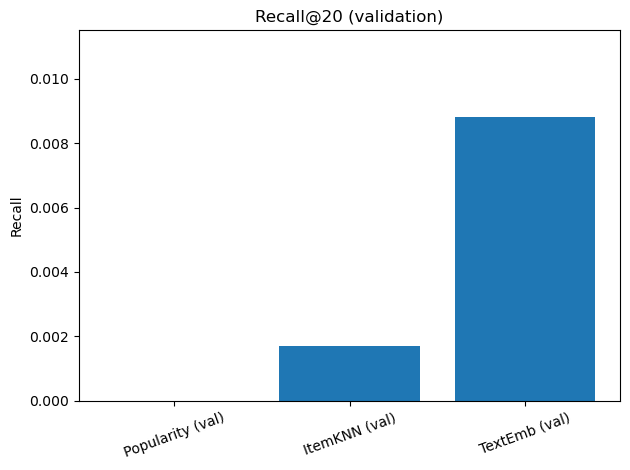

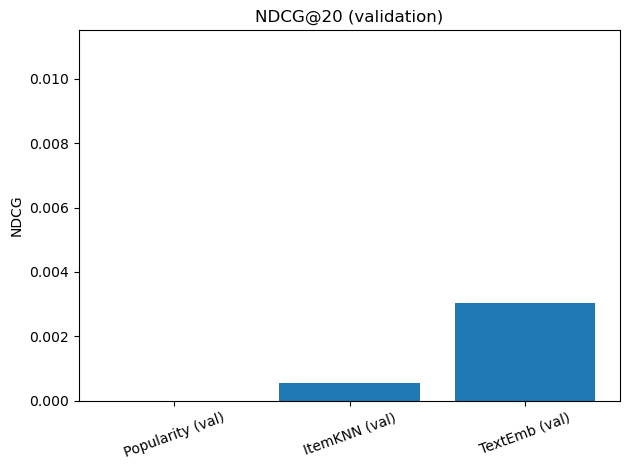

In [6]:

# --- Plot metrics summary -----------------------------------------------------
metrics_path = OUT_DIR / 'metrics_baselines.json'
if metrics_path.exists():
    with open(metrics_path, 'r', encoding='utf-8') as f:
        metrics_all = json.load(f)
else:
    metrics_all = {}

def collect(metric_key, keys):
    vals = []
    for k in keys:
        vals.append(metrics_all.get(k, {}).get(metric_key, 0.0))
    return vals

labels = ['Popularity (val)','ItemKNN (val)','TextEmb (val)']
keys   = ['popularity_val','itemknn_val','textemb_val']

vals_recall = collect('Recall@20', keys)
vals_ndcg   = collect('NDCG@20', keys)

# Plot Recall@20
plt.figure()
plt.bar(labels, vals_recall)
plt.title('Recall@20 (validation)')
plt.xticks(rotation=20)
plt.ylim(0, max(vals_recall+[0.01]) * 1.15)
plt.ylabel('Recall')
plt.tight_layout()
plt.show()

# Plot NDCG@20
plt.figure()
plt.bar(labels, vals_ndcg)
plt.title('NDCG@20 (validation)')
plt.xticks(rotation=20)
plt.ylim(0, max(vals_ndcg+[0.01]) * 1.15)
plt.ylabel('NDCG')
plt.tight_layout()
plt.show()



### Next
Proceed to **03_retriever_and_index.ipynb** to train a two‑tower retriever and build the FAISS/ScaNN index.  
Keep the best baseline metrics here as a reference for expected performance.
